In [1]:
%reset -fs

In [2]:
import pandas as pd
import numpy as np
import string
import re
import spacy
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from corextopic import corextopic as ct
from corextopic import vis_topic as vt
from matplotlib import pyplot as plt
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import minmax_scale
import seaborn as sns
%matplotlib inline

C:\Users\nated\anaconda3\lib\site-packages\matplotlib_inline\config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [3]:
stop_words = text.ENGLISH_STOP_WORDS.union(['nof', 'nthe', 'nand', 'nto', 'nin', 'nit', 'nfor', 'na', 'nthat', 'nbe', 'applause', 'nwhich', 'nis', 'nare', 'ni', 'nnot', 'nby', 'nhave', 'nbut', 'nwe', 'nwith', 'nfrom', 'nwill', 'nhas', 'nan', 'nif', 'nour'])

In [4]:
df = pd.read_csv('sotu_texts.csv')
df

,President,Year,Title,Text
0,George Washington,1790,First State of the Union Address,['I embrace with great satisfaction the opport...
1,George Washington,1790,Second State of the Union Address,['Fellow-Citizens of the Senate and the House ...
2,George Washington,1791,Third State of the Union Address,['Fellow-Citizens of the Senate and the House ...
3,George Washington,1792,Fourth State of the Union Address,['Fellow-Citizens of the Senate and of the Hou...
4,George Washington,1793,Fifth State of the Union Address,['Fellow Citizens of the Senate and of the Hou...
...,...,...,...,...
215,Barack Obama,2016,Barack Obama's Eighth State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ..."
216,Donald Trump,2017,Donald Trump's First State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ..."
217,Donald Trump,2018,Donald Trump's Second State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ..."
218,Donald Trump,2019,Donald Trump's Third State of the Union Address,"['Madam Speaker, Mr. Vice President, Members o..."


In [5]:
alphanumeric = lambda x: re.sub(r'\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

df['new_text'] = df.Text.map(alphanumeric).map(punc_lower)

In [6]:
nlp = spacy.load("en_core_web_sm")
docs = nlp.pipe(df.Text)

In [7]:
docs_clean = [[w.lemma_.lower() for w in doc if (not w.is_stop and not w.is_punct and not w.like_num)] for doc in docs]
df['docs_clean'] = docs_clean

In [8]:
docs_list_clean = [' '.join(doc) for doc in docs_clean]


In [9]:
count_vec = CountVectorizer(stop_words=stop_words, ngram_range=(1,3), min_df=2, max_df=219)
count_vec_X = count_vec.fit_transform(docs_list_clean)

In [10]:
num_topics = 10
SVD_topics = TruncatedSVD(num_topics)
doc_topic = SVD_topics.fit_transform(count_vec_X)

In [11]:
topic_word = pd.DataFrame(SVD_topics.components_.round(3),
             columns = count_vec.get_feature_names_out())

In [12]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [13]:
display_topics(SVD_topics, count_vec.get_feature_names_out(), 10)


Topic  0
government, year, congress, united, united states, country, great, law, people, nation

Topic  1
program, year, world, new, work, need, help, america, nation, federal

Topic  2
program, dollar, year, fiscal, fiscal year, war, united, expenditure, policy, united states

Topic  3
man, law, dollar, business, service, court, legislation, national, department, need

Topic  4
administration, energy, policy, congress, united states, effort, area, continue, provide, development

Topic  5
year, work, report, department, american, america, secretary, cent, office, fiscal year

Topic  6
mexico, united, war, united states, american, texas, mexican, army, foreign, peace

Topic  7
mexico, public, country, bank, department, texas, congress, business, constitution, tariff

Topic  8
mexico, year, country, texas, law, increase, man, mexican, land, number

Topic  9
world, free, great, year, department, secretary, report, increase, peace, war


In [14]:
tfidf_vec = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,3), min_df=2, max_df=219)
tfidf_X = tfidf_vec.fit_transform(docs_list_clean)

In [15]:
doc_topic = SVD_topics.fit_transform(tfidf_X)

In [16]:
display_topics(SVD_topics, tfidf_vec.get_feature_names_out(), 10)


Topic  0
government, year, congress, united, united states, country, people, great, nation, law

Topic  1
america, job, tonight, world, help, program, americans, new, people, year

Topic  2
program, economic, federal, world, problem, national, farm, increase, development, need

Topic  3
cent, year, work, department, law, court, silver, secretary, business, report

Topic  4
man, war, interstate, great, law, corporation, business, work, good, industrial

Topic  5
war, world, fight, man, united, enemy, free, nations, soviet, japanese

Topic  6
government, mexico, people, constitution, texas, bank, duty, congress, power, kansas

Topic  7
iraq, terrorist, iraqi, terror, al, regime, america, saddam, qaeda, al qaeda

Topic  8
war, silver, enemy, treasury, bank, fiscal year, job, debt, gold, circulation

Topic  9
war, spain, job, british, production, united, veteran, depression, enemy, colony


In [17]:
LDA_topics = LatentDirichletAllocation(n_components=10)

In [18]:
count_vec_X = count_vec.fit_transform(docs_list_clean)

In [19]:
doc_topic = LDA_topics.fit_transform(count_vec_X)

In [20]:
display_topics(LDA_topics, count_vec.get_feature_names_out(), 10)


Topic  0
country troop, tackle, repair damage, restore great, irreplaceable natural resource, irreplaceable natural, social evil, consider series, community institution, disease suffering

Topic  1
government, united, united states, congress, year, country, great, law, public, people

Topic  2
banking, reconstruction finance, reconstruction finance corporation, bank failure, banks, finance corporation, reconstruction, recovery, furlough, federal public work

Topic  3
year, america, work, people, child, new, help, americans, know, job

Topic  4
restore world, deny equal, citizen deny, percent retail price, percent retail, retail price, people consist, support expand, sufficient fund, seriously limit

Topic  5
world, nation, war, people, year, great, peace, government, free, congress

Topic  6
year, new, world, people, nation, congress, government, american, program, america

Topic  7
discriminate duty, discriminate, peace establishment, penitentiary, gradual increase navy, board engine

In [21]:
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(LDA_topics, count_vec_X, count_vec, mds='mmds')

C:\Users\nated\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\nated\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.021962  0.187646       1        1  50.410908
8     -0.007418  0.233500       2        1  18.465852
6     -0.241217  0.036147       3        1  16.884930
5     -0.169286  0.124817       4        1   8.397021
3     -0.213117 -0.126177       5        1   5.656126
7      0.118299 -0.108942       6        1   0.111989
2      0.129859 -0.089462       7        1   0.056578
4      0.121038 -0.086338       8        1   0.012866
0      0.119941 -0.085596       9        1   0.001865
9      0.119941 -0.085595      10        1   0.001865, topic_info=                   Term         Freq        Total Category  logprob  loglift
124356             year  6004.000000  6004.000000  Default  30.0000  30.0000
80734            people  3929.000000  3929.000000  Default  29.0000  29.0000
123142             work  2523.000000  2523.000000  Default  28.0000  28.0000
123755            world  2295.000000  2295.000000  Default  27.0000  27.0000
4860            america  1542.000000  1542.000000  Default  26.0000  26.0000
...                 ...          ...          ...      ...      ...      ...
41821     faith society     0.000175     2.338577  Topic10 -11.7411   1.3898
121616          war sum     0.000175     2.338577  Topic10 -11.7411   1.3898
50649   growth national     0.000175     2.338577  Topic10 -11.7411   1.3898
60337       june expect     0.000175     2.338578  Topic10 -11.7411   1.3898
66833    man individual     0.000175     2.263580  Topic10 -11.7411   1.4224

[782 rows x 6 columns], token_table=        Topic      Freq                           Term
term                                                  
22          1  0.822917                           1960
515         3  0.625633                   accept peace
619         1  0.999736  accompanying report secretary
980         3  0.976560                   achieve goal
1175        1  0.571909                            act
...       ...       ...                            ...
124356      1  0.422531                           year
124356      2  0.150725                           year
124356      3  0.283464                           year
124356      4  0.067951                           year
124356      5  0.075446                           year

[1309 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 9, 7, 6, 4, 8, 3, 5, 1, 10])

In [22]:
tfidf_X = tfidf_vec.fit_transform(docs_list_clean)

In [23]:
doc_topic = LDA_topics.fit_transform(tfidf_X)

In [24]:
display_topics(LDA_topics, tfidf_vec.get_feature_names_out(), 10)


Topic  0
sponsor, medical care, truck, mayor, underworld, today create, europe stand, waste natural, waste natural resource, economy act

Topic  1
sponsor, medical care, truck, mayor, underworld, today create, europe stand, waste natural, waste natural resource, economy act

Topic  2
sponsor, medical care, truck, mayor, underworld, today create, europe stand, waste natural, waste natural resource, economy act

Topic  3
national industrial, national industrial recovery, industrial recovery act, process recovery, industrial recovery, recovery act, task legislative, problem modern civilization, adequate pay, unemployment need

Topic  4
sponsor, medical care, truck, mayor, underworld, today create, europe stand, waste natural, waste natural resource, economy act

Topic  5
government, year, congress, united, country, united states, people, great, nation, law

Topic  6
sponsor, medical care, truck, mayor, underworld, today create, europe stand, waste natural, waste natural resource, economy

In [25]:
pyLDAvis.sklearn.prepare(LDA_topics, tfidf_X, tfidf_vec, mds='mmds')

C:\Users\nated\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\nated\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.022134  0.031281       1        1  83.971589
7      0.007764 -0.010313       2        1  14.230854
3      0.001835 -0.002593       3        1   0.224695
0      0.001761 -0.002647       4        1   0.224695
1      0.001763 -0.002645       5        1   0.224695
2      0.001827 -0.002598       6        1   0.224695
4      0.001821 -0.002603       7        1   0.224695
6      0.001761 -0.002647       8        1   0.224695
8      0.001813 -0.002608       9        1   0.224695
9      0.001789 -0.002626      10        1   0.224695, topic_info=                        Term      Freq     Total Category  logprob  loglift
4860                 america  1.000000  1.000000  Default  30.0000  30.0000
87910                program  0.000000  0.000000  Default  29.0000  29.0000
47853             government  8.000000  8.000000  Default  28.0000  28.0000
51846                   help  0.000000  0.000000  Default  27.0000  27.0000
21275               congress  5.000000  5.000000  Default  26.0000  26.0000
...                      ...       ...       ...      ...      ...      ...
50628           growth final  0.000171  0.068263  Topic10 -11.7411   0.1084
117618             unethical  0.000171  0.066000  Topic10 -11.7411   0.1421
8276     assistance national  0.000171  0.067605  Topic10 -11.7411   0.1181
19316            commonsense  0.000171  0.073552  Topic10 -11.7411   0.0338
18104   come american people  0.000171  0.067674  Topic10 -11.7411   0.1171

[594 rows x 6 columns], token_table=        Topic      Freq           Term
term                                  
1175        1  1.102411            act
4860        1  0.732412        america
4860        2  0.732412        america
5171        1  0.979615       american
16314       1  1.177190        citizen
21275       1  1.040181       congress
25348       1  1.000315        country
29612       1  0.942885     department
33228       1  0.811718           duty
44220       1  0.978693          force
46687       1  0.873601        general
47460       1  1.113303           good
47853       1  0.980630     government
49601       1  1.028684          great
51576       1  1.346698         health
51846       2  1.261873           help
55690       1  1.015820       increase
59783       2  1.797181            job
62179       1  1.047060            law
63822       1  1.266993            let
66692       1  0.901059            man
71365       1  1.074947         nation
72072       1  1.156677       national
73097       1  0.958812      necessary
73515       1  0.807499           need
74229       1  0.931542            new
80136       1  0.805443          peace
80734       1  1.014640         people
84394       1  0.917334          power
85451       1  0.944330        present
87910       2  1.235848        program
90544       1  1.112203         public
99535       1  1.181662          right
101334      1  1.337506         school
103161      1  0.865799        service
103941      1  1.052194          shall
110197      1  1.145509        subject
112642      1  0.976249            tax
114273      1  1.049745           time
116300      1  0.904415         treaty
118049      1  0.950693         united
118085      1  1.009120  united states
121156      1  0.859577            war
123142      1  1.046939           work
123755      1  0.985210          world
124356      1  1.009731           year, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 8, 4, 1, 2, 3, 5, 7, 9, 10])

In [26]:
doc_word = count_vec.fit_transform(docs_list_clean)
words = list(np.asarray(count_vec.get_feature_names_out()))

In [27]:
topic_model = ct.Corex(n_hidden=10, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=docs_list_clean)

In [28]:
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: appointment,interested,states government,interstate commerce,promptly,local self government,local self,commend,united states government,pan
1: fight,set,school,training,legislation enact,enact,deficit,recognize,diplomacy,criminal
2: history,attendance,substantial,end june expenditure,total number,shortly submit,rate year,profitably,year increase,evil
3: imputation,thousand mile,concede,duty united,duty united states,colleague,congress far,result policy,congress proper,rebate
4: cash receipt,joy,scrip,challenge time,grateful acknowledgment,present administration,june expenditure,land warrant,locate military,congress exercise
5: ideology,ask join,commence,social security medicare,productive,industrial country,job job,year special,close communication,adventurer
6: pro,tenure office,ireland,bring attention congress,able meet,principle public,force nation,national safety,genius,assess
7: happy effect,social political,student loan,great improvement,cancer,tax incentive,demand government,l

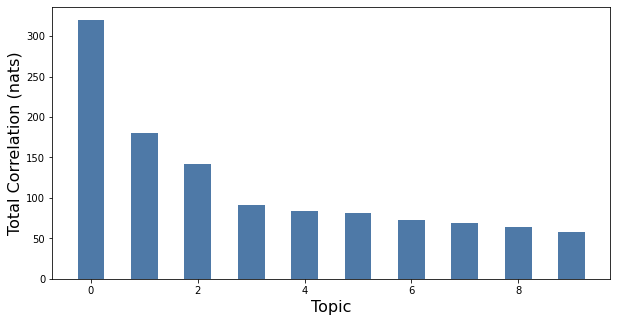

In [29]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [30]:
topic_model = ct.Corex(n_hidden=10, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=docs_list_clean, anchors=[['economy', 'job', 'work', 'program', 'employment'], ['manufacturing', 'production', 'build', 'commerce', 'business', 'farmer', 'agriculture', 'crop', 'private business', 'farm', 'land'], ['government', 'america', 'american', 'people', 'constitution', 'country', 'congress', 'united', 'people', 'nation', 'federal'], ['money', 'expenditure', 'tax', 'fiscal', 'treasury', 'stimulus', 'income', 'dollar', 'currency', 'tariff', 'debt', 'cent', 'bank', 'home'], ['protest', 'race', 'movement', 'strike', 'black', 'indian', 'latino', 'slave', 'civil','right','liberty', 'immigration', 'mexico', 'dreamer', 'citizenship'], ['germany', 'france', 'spain', 'nato', 'europe', 'hitler', 'japan', 'japanese', 'nazi', 'putin', 'ukraine', 'korea', 'soviet', 'ukraine', 'british', 'cuba', 'venezuela', 'iran', 'china', 'russia', 'canada', 'war', 'fight', 'vietnam', 'alliance', 'adversary', 'enemy', 'international', 'german', 'navy', 'military', 'troop', 'sea power', 'admiral', 'general', 'iraqi', 'iraq', 'insurgent', 'terrorist', 'saddam', 'kuwait', 'syria', 'israel', 'panama', 'army', 'peace', 'afghanistan', 'al qaeda', 'taliban', 'islamic', 'defense', 'treaty'], ['energy', 'atomic', 'renewable', 'oil', 'research', 'science', 'innovation', 'cyber', 'space', 'moon', 'rocket', 'cancer', 'health', 'industrial', 'pandemic'], ['law', 'order', 'court', 'crime', 'gang', 'police', 'safe', 'gun', 'sedition', 'communist', 'communism'], ['college', 'school', 'education', 'degree', 'math', 'student',  'education', 'university'], ['road', 'bridge', 'airplane', 'interstate', 'airport', 'highway', 'port', 'dock', 'shipyard', 'railway', 'infrastructure']], anchor_strength=2)

In [31]:
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: job,program,today,goal,economic,budget,help,house representatives,basic,representatives
1: manufacturing,production,crop,present law,advocate,widely,farmer,requirement,business,import
2: american,successor,tenure,america,ask,set apart,genius,example,tenure office,follow
3: cent,currency,expenditure,fiscal,tariff,year end june,interior,fiscal year end,treasury,end june
4: mexico,civil,indian,protest,constitute,report secretary navy,class,compose,tribunal,complaint
5: china,rule,russia,germany,navy,england,japanese,army,provide appointment,cuba
6: research,long term,affordable,big,energy,street,cancer,help people,health,renewable
7: crime,safe,police,communism,pay,teach,gun,half,bring cost,prison
8: student,school,education,college,deficit,university,young,enforcement,chamber,record
9: interstate,railway,bridge,road,highway,company,criminal,department justice,strongly,municipal


In [32]:
vt.vis_rep(topic_model, column_label=words, prefix='sotu-model')

Print topics in text file


C:\Users\nated\anaconda3\lib\site-packages\fontTools\misc\py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


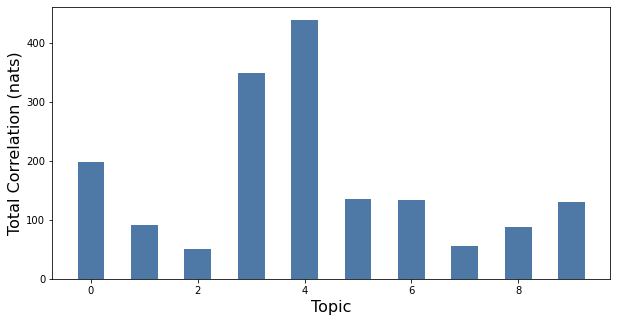

In [33]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);
plt.savefig('topic_graph.png')

In [34]:
predictions = pd.DataFrame(topic_model.log_p_y_given_x, columns=['Economy/Labor', 'Economy/Manufacturing', 'Government/Federalism/States', 'Finances/Budget', 'Social Issues', 'Foreign Policy', 'Science and Technology', 'Crime/Law/Jurisprudence', 'Education', 'Infrastructure'])
predictions['top_topics']=predictions.idxmax(axis=1)
predictions


,Economy/Labor,Economy/Manufacturing,Government/Federalism/States,Finances/Budget,Social Issues,Foreign Policy,Science and Technology,Crime/Law/Jurisprudence,Education,Infrastructure,top_topics
0,-689.738980,-349.766783,-182.122179,-1667.878714,-1360.908642,-435.978261,-433.098832,-179.135363,-343.955667,-397.587301,Crime/Law/Jurisprudence
1,-897.082529,-365.653721,-150.812359,-1556.692449,-1365.351732,-421.669513,-436.501720,-181.037151,-350.069661,-409.954968,Government/Federalism/States
2,-1557.782044,-337.104070,-179.095535,-1315.516377,-1326.465336,-422.959144,-461.232172,-417.342391,-387.136335,-383.259366,Government/Federalism/States
3,-1421.375162,-345.651227,-187.271937,-1345.175120,-1329.894841,-423.954361,-422.136710,-360.833771,-374.093101,-396.610285,Government/Federalism/States
4,-1346.571151,-356.527798,-183.451244,-1304.028064,-1328.095852,-391.534050,-466.872228,-349.182676,-369.837029,-401.402680,Government/Federalism/States
...,...,...,...,...,...,...,...,...,...,...,...
215,0.000000,0.000000,0.000000,-1719.060672,0.000000,0.000000,0.000000,-61.382014,0.000000,-401.574824,Economy/Labor
216,0.000000,-380.233803,0.000000,-1689.332182,-1355.397915,0.000000,0.000000,0.000000,0.000000,0.000000,Economy/Labor
217,0.000000,-333.958551,-203.124105,-1643.048879,-1340.934517,-413.421395,0.000000,0.000000,0.000000,0.000000,Economy/Labor
218,0.000000,-354.765901,0.000000,-1678.457599,-1346.945037,0.000000,0.000000,0.000000,0.000000,0.000000,Economy/Labor


In [35]:
df['top_topic'] = predictions.top_topics

In [36]:
df

,President,Year,Title,Text,new_text,docs_clean,top_topic
0,George Washington,1790,First State of the Union Address,['I embrace with great satisfaction the opport...,i embrace with great satisfaction the opport...,"[embrace, great, satisfaction, opportunity, pr...",Crime/Law/Jurisprudence
1,George Washington,1790,Second State of the Union Address,['Fellow-Citizens of the Senate and the House ...,fellow citizens of the senate and the house ...,"[fellow, citizens, senate, house, representati...",Government/Federalism/States
2,George Washington,1791,Third State of the Union Address,['Fellow-Citizens of the Senate and the House ...,fellow citizens of the senate and the house ...,"[fellow, citizens, senate, house, representati...",Government/Federalism/States
3,George Washington,1792,Fourth State of the Union Address,['Fellow-Citizens of the Senate and of the Hou...,fellow citizens of the senate and of the hou...,"[fellow, citizens, senate, house, representati...",Government/Federalism/States
4,George Washington,1793,Fifth State of the Union Address,['Fellow Citizens of the Senate and of the Hou...,fellow citizens of the senate and of the hou...,"[fellow, citizens, senate, house, representati...",Government/Federalism/States
...,...,...,...,...,...,...,...
215,Barack Obama,2016,Barack Obama's Eighth State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ...",mr speaker mr vice president members of ...,"[mr., speaker, mr., vice, president, members, ...",Economy/Labor
216,Donald Trump,2017,Donald Trump's First State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ...",mr speaker mr vice president members of ...,"[mr., speaker, mr., vice, president, members, ...",Economy/Labor
217,Donald Trump,2018,Donald Trump's Second State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ...",mr speaker mr vice president members of ...,"[mr., speaker, mr., vice, president, members, ...",Economy/Labor
218,Donald Trump,2019,Donald Trump's Third State of the Union Address,"['Madam Speaker, Mr. Vice President, Members o...",madam speaker mr vice president members o...,"[madam, speaker, mr., vice, president, members...",Economy/Labor


In [37]:
predictions_scaled = minmax_scale(np.array(predictions.drop(columns=['top_topics']).values.T)).T
preds_df = pd.DataFrame(predictions_scaled, columns=['Economy/Labor', 'Economy/Manufacturing', 'Government/Federalism/States', 'Finances/Budget', 'Social Issues', 'Foreign Policy', 'Science and Technology', 'Crime/Law/Jurisprudence', 'Education', 'Infrastructure'])
mtx = preds_df.values

In [38]:
maren = KMeans(n_clusters=10, random_state=42)

In [39]:
maren.fit(mtx)

KMeans(n_clusters=10, random_state=42)

In [40]:
preds_df['Cluster'] = maren.labels_

In [41]:
preds_df.Cluster.value_counts()

2    63
1    30
6    27
0    25
7    21
4    17
3    15
8    12
5     6
9     4
Name: Cluster, dtype: int64

In [42]:
df_clusters = preds_df.groupby(['Cluster']).median()
df_clusters

,Economy/Labor,Economy/Manufacturing,Government/Federalism/States,Finances/Budget,Social Issues,Foreign Policy,Science and Technology,Crime/Law/Jurisprudence,Education,Infrastructure
Cluster,,,,,,,,,,
0,1.0,0.829005,0.871256,0.000000,0.015986,0.705120,0.711099,0.656506,0.745153,0.736052
1,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.859585,0.822467,0.911657,0.949652
2,1.0,0.802931,0.879502,0.000000,0.157351,0.746808,1.000000,1.000000,1.000000,0.755994
3,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
4,0.0,0.856936,1.000000,1.000000,0.174799,0.789954,0.654355,1.000000,0.710835,0.791756
5,1.0,0.761145,0.912185,1.000000,0.675294,0.876091,0.374650,1.000000,0.000000,0.673000
6,0.0,0.883179,1.000000,0.146045,0.169362,0.832808,0.796790,0.864919,0.838632,0.830372
7,0.0,0.870973,1.000000,1.000000,1.000000,0.755654,0.525607,1.000000,0.558176,1.000000
8,1.0,1.000000,0.925103,1.000000,0.000000,0.837067,0.815220,0.717900,1.000000,1.000000


In [43]:
[[num[0] for num in df_clusters.iloc[1].values.reshape(-1, 1).tolist()]]

[[0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.859585330537029,
  0.8224672719237817,
  0.9116568338956268,
  0.9496520496728752]]

In [44]:
top_3_docs = pairwise_distances([[num[0] for num in df_clusters.iloc[1].values.reshape(-1, 1).tolist()]], \
                                mtx,metric='euclidean').argsort()[0, :3]
df['Cluster']=maren.labels_

In [45]:
df.iloc[top_3_docs[2]]

President                                         James K. Polk
Year                                                       1846
Title                         Second State of the Union Address
Text          ['Fellow-Citizens of the Senate and of the Hou...
new_text        fellow citizens of the senate and of the hou...
docs_clean    [fellow, citizens, senate, house, representati...
top_topic                                 Economy/Manufacturing
Cluster                                                       1
Name: 50, dtype: object

In [46]:
preds_df.iloc[top_3_docs[2]]

Economy/Labor                   0.000000
Economy/Manufacturing           1.000000
Government/Federalism/States    1.000000
Finances/Budget                 1.000000
Social Issues                   1.000000
Foreign Policy                  1.000000
Science and Technology          1.000000
Crime/Law/Jurisprudence         0.720126
Education                       0.689349
Infrastructure                  1.000000
Cluster                         1.000000
Name: 50, dtype: float64

In [47]:
dfs = [df.drop(columns=['Cluster']), preds_df]
df_1 = pd.concat(dfs, axis=1)

In [48]:
df_1

,President,Year,Title,Text,new_text,docs_clean,top_topic,Economy/Labor,Economy/Manufacturing,Government/Federalism/States,Finances/Budget,Social Issues,Foreign Policy,Science and Technology,Crime/Law/Jurisprudence,Education,Infrastructure,Cluster
0,George Washington,1790,First State of the Union Address,['I embrace with great satisfaction the opport...,i embrace with great satisfaction the opport...,"[embrace, great, satisfaction, opportunity, pr...",Crime/Law/Jurisprudence,0.657024,0.885386,0.997994,0.000000,0.206194,0.827477,0.829411,1.000000,0.889289,0.853264,2
1,George Washington,1790,Second State of the Union Address,['Fellow-Citizens of the Senate and the House ...,fellow citizens of the senate and the house ...,"[fellow, citizens, senate, house, representati...",Government/Federalism/States,0.469179,0.847184,1.000000,0.000000,0.136100,0.807340,0.796790,0.978501,0.858269,0.815672,6
2,George Washington,1791,Third State of the Union Address,['Fellow-Citizens of the Senate and the House ...,fellow citizens of the senate and the house ...,"[fellow, citizens, senate, house, representati...",Government/Federalism/States,0.000000,0.885392,1.000000,0.175722,0.167780,0.823119,0.795358,0.827193,0.849102,0.851914,6
3,George Washington,1792,Fourth State of the Union Address,['Fellow-Citizens of the Senate and of the Hou...,fellow citizens of the senate and of the hou...,"[fellow, citizens, senate, house, representati...",Government/Federalism/States,0.000000,0.871664,1.000000,0.061745,0.074127,0.808215,0.809688,0.859362,0.848618,0.830372,6
4,George Washington,1793,Fifth State of the Union Address,['Fellow Citizens of the Senate and of the Hou...,fellow citizens of the senate and of the hou...,"[fellow, citizens, senate, house, representati...",Government/Federalism/States,0.000000,0.851196,1.000000,0.036577,0.015884,0.821099,0.756327,0.857511,0.839754,0.812615,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,Barack Obama,2016,Barack Obama's Eighth State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ...",mr speaker mr vice president members of ...,"[mr., speaker, mr., vice, president, members, ...",Economy/Labor,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.964293,1.000000,0.766399,2
216,Donald Trump,2017,Donald Trump's First State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ...",mr speaker mr vice president members of ...,"[mr., speaker, mr., vice, president, members, ...",Economy/Labor,1.000000,0.774921,1.000000,0.000000,0.197672,1.000000,1.000000,1.000000,1.000000,1.000000,2
217,Donald Trump,2018,Donald Trump's Second State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ...",mr speaker mr vice president members of ...,"[mr., speaker, mr., vice, president, members, ...",Economy/Labor,1.000000,0.796745,0.876374,0.000000,0.183874,0.748382,1.000000,1.000000,1.000000,1.000000,2
218,Donald Trump,2019,Donald Trump's Third State of the Union Address,"['Madam Speaker, Mr. Vice President, Members o...",madam speaker mr vice president members o...,"[madam, speaker, mr., vice, president, members...",Economy/Labor,1.000000,0.788636,1.000000,0.000000,0.197510,1.000000,1.000000,1.000000,1.000000,1.000000,2


In [49]:
df_1.to_csv('sotu_clusters.csv')

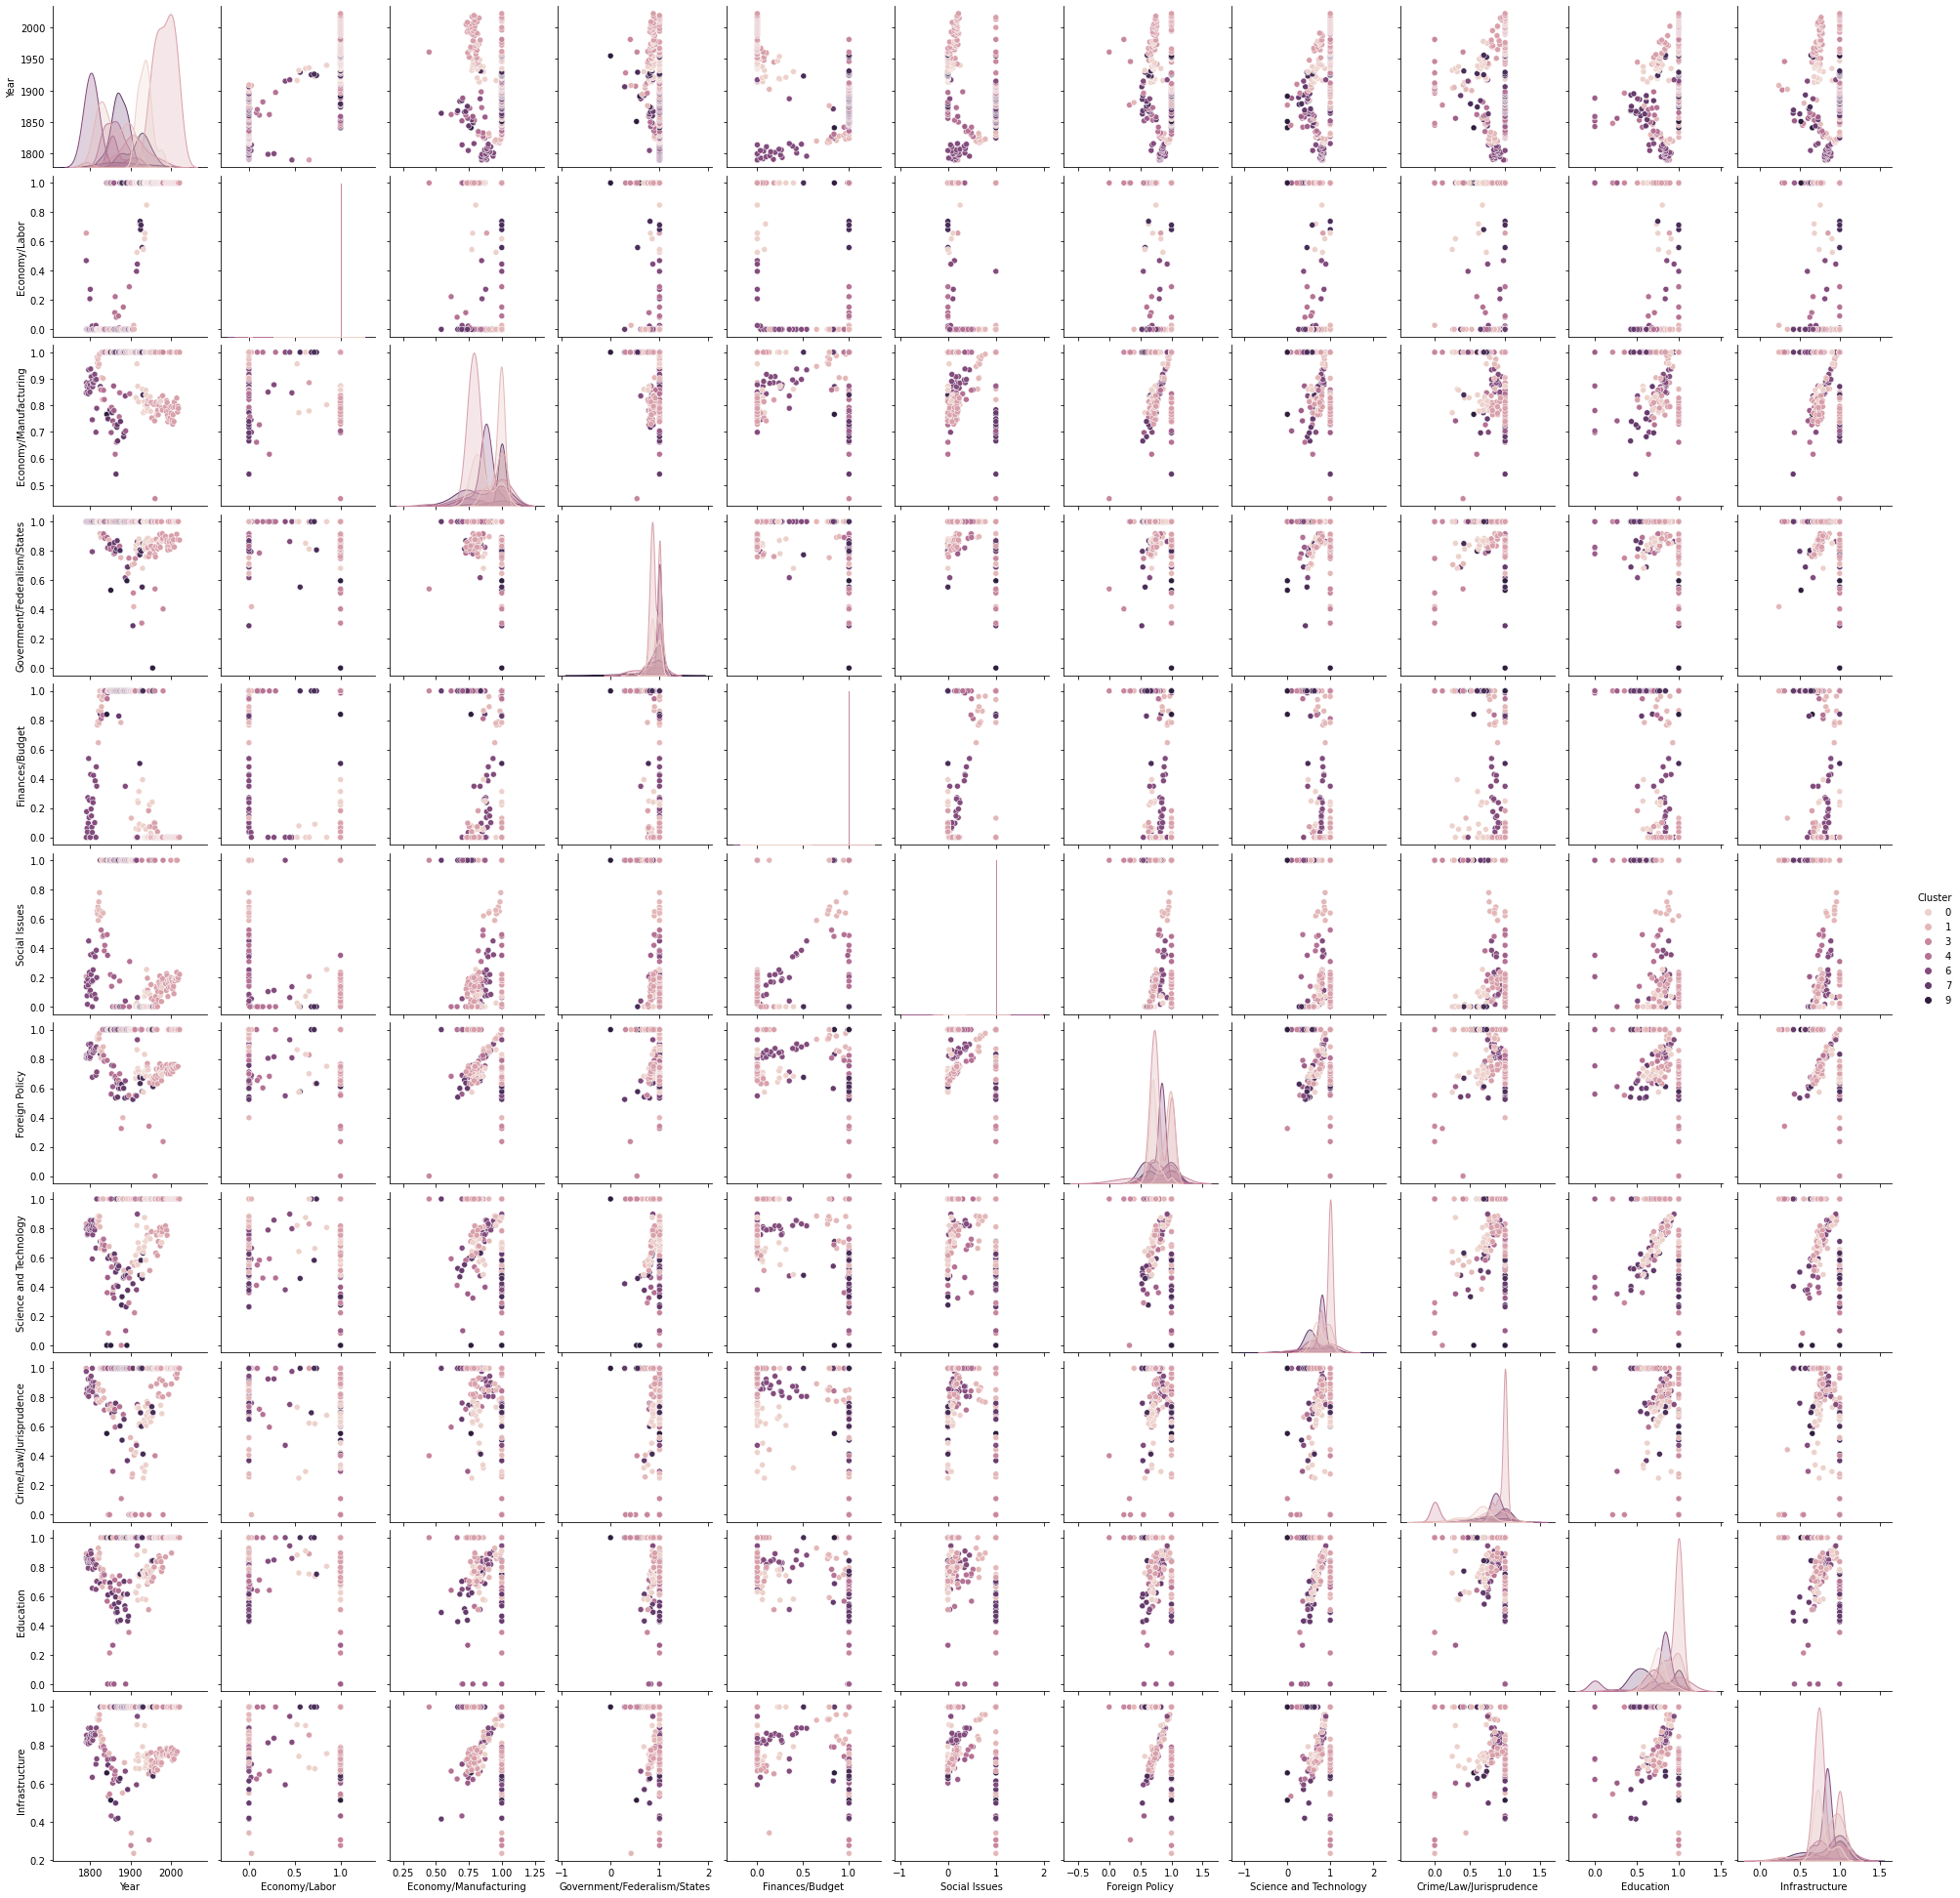

In [50]:
sns.pairplot(df_1, hue='Cluster')

In [51]:
sort_speeches = df_1.sort_values(['Cluster'])
sort_speeches

,President,Year,Title,Text,new_text,docs_clean,top_topic,Economy/Labor,Economy/Manufacturing,Government/Federalism/States,Finances/Budget,Social Issues,Foreign Policy,Science and Technology,Crime/Law/Jurisprudence,Education,Infrastructure,Cluster
117,Woodrow Wilson,1913,First State of the Union Address,"['Gentlemen of the Congress:', 'In pursuance o...",gentlemen of the congress in pursuance o...,"[gentleman, congress, pursuance, constitutiona...",Economy/Labor,1.000000,0.828253,0.812311,0.000000,0.015986,0.666729,0.614827,0.425544,0.629082,0.679296,0
180,Gerald Ford,1975,First State of the Union Address,"['Twenty-six years ago, a freshman Congressman...",twenty six years ago a freshman congressman...,"[year, ago, freshman, congressman, young, , f...",Economy/Labor,1.000000,0.816004,0.872445,0.000000,0.077453,0.705120,0.753631,0.747369,0.789597,0.736052,0
158,Dwight D. Eisenhower,1954,Second State of the Union Address,"['Mr. President, Mr. Speaker, Members of the E...",mr president mr speaker members of the e...,"[mr., president, mr., speaker, members, congre...",Economy/Labor,1.000000,1.000000,0.871256,0.240743,0.000000,0.669049,1.000000,0.672298,0.781816,1.000000,0
153,Harry S. Truman,1950,Fifth State of the Union Address,"['Mr. President, Mr. Speaker, Members of the C...",mr president mr speaker members of the c...,"[mr., president, mr., speaker, members, congre...",Economy/Labor,1.000000,0.777636,0.835612,0.028706,0.000000,1.000000,1.000000,0.633940,0.757373,0.686808,0
152,Harry S. Truman,1949,Fourth State of the Union Address,"['Mr. President, Mr. Speaker, Members of the C...",mr president mr speaker members of the c...,"[mr., president, mr., speaker, members, congre...",Economy/Labor,1.000000,0.832075,0.858593,0.000000,0.080848,0.680175,0.727138,0.708728,0.718750,0.715145,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,Calvin Coolidge,1924,Second State of the Union Address,"['To the Congress of the United States:', 'The...",to the congress of the united states the...,"[congress, united, states, present, state, uni...",Economy/Manufacturing,0.737731,1.000000,0.806625,1.000000,0.000000,0.631713,1.000000,1.000000,0.750478,1.000000,8
45,John Tyler,1841,First State of the Union Address,['To the Senate and House of Representatives o...,to the senate and house of representatives o...,"[senate, house, representatives, united, state...",Economy/Labor,1.000000,0.766347,1.000000,0.840026,1.000000,1.000000,0.000000,0.554936,1.000000,0.655465,9
55,Millard Fillmore,1851,Second State of the Union Address,['\nFellow-Citizens of the Senate and of the H...,nfellow citizens of the senate and of the h...,"[\nfellow, citizens, senate, house, representa...",Economy/Labor,1.000000,1.000000,0.530979,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.512591,9
159,Dwight D. Eisenhower,1955,Third State of the Union Address,"['Mr. President, Mr. Speaker, Members of the C...",mr president mr speaker members of the c...,"[mr., president, mr., speaker, members, congre...",Economy/Labor,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9


In [52]:
sort_speeches[sort_speeches.Cluster==1]

,President,Year,Title,Text,new_text,docs_clean,top_topic,Economy/Labor,Economy/Manufacturing,Government/Federalism/States,Finances/Budget,Social Issues,Foreign Policy,Science and Technology,Crime/Law/Jurisprudence,Education,Infrastructure,Cluster
61,James Buchanan,1857,First State of the Union Address,['Fellow-Citizens of the Senate and House of R...,fellow citizens of the senate and house of r...,"[fellow, citizens, senate, house, representati...",Economy/Manufacturing,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.383326,0.666682,1.000000,1.000000,1
98,Grover Cleveland,1894,Sixth State of the Union Address,"['', 'To the Congress of the United States:', ...",to the congress of the united states ...,"[congress, united, states, assemblage, nation,...",Economy/Manufacturing,0.000000,1.000000,0.646136,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1
113,William Howard Taft,1909,First State of the Union Address,['The relations of the United States with all ...,the relations of the united states with all ...,"[relation, united, states, foreign, government...",Economy/Manufacturing,0.000000,1.000000,0.712003,1.000000,1.000000,1.000000,0.546468,0.406604,1.000000,1.000000,1
51,James K. Polk,1847,Third State of the Union Address,['Fellow-Citizens of the Senate and of the Hou...,fellow citizens of the senate and of the hou...,"[fellow, citizens, senate, house, representati...",Economy/Manufacturing,0.000000,1.000000,0.873496,1.000000,1.000000,1.000000,0.675057,0.718443,1.000000,0.757504,1
50,James K. Polk,1846,Second State of the Union Address,['Fellow-Citizens of the Senate and of the Hou...,fellow citizens of the senate and of the hou...,"[fellow, citizens, senate, house, representati...",Economy/Manufacturing,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.720126,0.689349,1.000000,1
59,Franklin Pierce,1855,Third State of the Union Address,['Fellow-Citizens of the Senate and of the Hou...,fellow citizens of the senate and of the hou...,"[fellow, citizens, senate, house, representati...",Economy/Manufacturing,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.616048,0.739734,0.734703,1.000000,1
112,Theodore Roosevelt,1908,Eighth State of the Union Address,['To the Senate and House of Representatives:'...,to the senate and house of representatives ...,"[senate, house, representatives, finance, fina...",Economy/Manufacturing,0.027485,1.000000,0.418989,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.234765,1
84,Rutherford B. Hayes,1880,Fourth State of the Union Address,['Fellow-Citizens of the Senate and House of R...,fellow citizens of the senate and house of r...,"[fellow, citizens, senate, house, representati...",Economy/Manufacturing,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.550700,1
108,Theodore Roosevelt,1904,Fourth State of the Union Address,['To the Senate and House of Representatives:'...,to the senate and house of representatives ...,"[senate, house, representatives, nation, conti...",Economy/Manufacturing,0.000000,1.000000,0.705935,1.000000,1.000000,1.000000,0.564560,0.257802,1.000000,1.000000,1
85,Chester A. Arthur,1881,First State of the Union Address,['To the Senate and House of Representatives o...,to the senate and house of representatives o...,"[senate, house, representatives, united, state...",Economy/Manufacturing,0.000000,1.000000,1.000000,1.000000,1.000000,0.398016,1.000000,1.000000,1.000000,1.000000,1
